<a href="https://colab.research.google.com/github/snehabn/thinkful_capstone3/blob/main/Capstone3_SNarasimhan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goodreads Book Recommendation Case Study
### Unsupervised Learning
Sneha Narasimhan

Thinkful Capstone 3

## Introduction

Most avid readers have a "TBR" (to-be-read) list somewhere, a place where they collect names of books or authors that they want to read. Goodreads is a social website and application used by many, that helps users keep track of books that they have read, want to read, and/or currently reading. It also provides recommendations based on the user's activity and shows what the user's friends' activities [1].

This [Goodreads-books dataset](https://www.kaggle.com/datasets/jealousleopard/goodreadsbooks) from Kaggle provides mostly clean data derived from the Goodreads API [2]. In this case study, we will explore different unsupervised learning models to determine the most optimal one that can be used to recommend books.



---



---



# Data Setup


In [ ]:
# Import dependencies and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

!pip install umap-learn
import umap

In [ ]:
# Read data from csv
data = pd.read_csv('https://raw.githubusercontent.com/snehabn/thinkful_capstone3/main/books.csv',  on_bad_lines='skip')
print(data.info())
print('Dimensions:', data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11123 entries, 0 to 11122
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              11123 non-null  int64  
 1   title               11123 non-null  object 
 2   authors             11123 non-null  object 
 3   average_rating      11123 non-null  float64
 4   isbn                11123 non-null  object 
 5   isbn13              11123 non-null  int64  
 6   language_code       11123 non-null  object 
 7     num_pages         11123 non-null  int64  
 8   ratings_count       11123 non-null  int64  
 9   text_reviews_count  11123 non-null  int64  
 10  publication_date    11123 non-null  object 
 11  publisher           11123 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.0+ MB
None
Dimensions: (11123, 12)


In [ ]:
len(data['title'].unique())

10348



---



---



## Feature Engineering
### Data Preview

In this section we will explore, understand, and standardize the contents of the dataset.

In [ ]:
column_names = list(data.columns.values)
print(column_names)

['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13', 'language_code', '  num_pages', 'ratings_count', 'text_reviews_count', 'publication_date', 'publisher']


The column name, `'   num_pages'` , needs to be corrected for spacing.

In [ ]:
data.rename(columns={"  num_pages":"number_pages"}, inplace=True)

In [ ]:
column_names = list(data.columns.values)
print(column_names)

['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13', 'language_code', 'number_pages', 'ratings_count', 'text_reviews_count', 'publication_date', 'publisher']


In [ ]:
# Checking for nulls in DataFrame
print('Nulls in df: ', data.isnull().values.any())
print('Sum of nulls: ', data.isnull().sum())

Nulls in df:  False
Sum of nulls:  bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
number_pages          0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
dtype: int64


In [ ]:
data.duplicated().sum()

0

In [ ]:
data.describe()

,bookID,average_rating,isbn13,number_pages,ratings_count,text_reviews_count
count,11123.000000,11123.000000,1.112300e+04,11123.000000,1.112300e+04,11123.000000
mean,21310.856963,3.934075,9.759880e+12,336.405556,1.794285e+04,542.048099
std,13094.727252,0.350485,4.429758e+11,241.152626,1.124992e+05,2576.619589
min,1.000000,0.000000,8.987060e+09,0.000000,0.000000e+00,0.000000
25%,10277.500000,3.770000,9.780345e+12,192.000000,1.040000e+02,9.000000
50%,20287.000000,3.960000,9.780582e+12,299.000000,7.450000e+02,47.000000
75%,32104.500000,4.140000,9.780872e+12,416.000000,5.000500e+03,238.000000
max,45641.000000,5.000000,9.790008e+12,6576.000000,4.597666e+06,94265.000000


In [ ]:
data.head(5)

,bookID,title,authors,average_rating,isbn,isbn13,language_code,number_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic



Feature Descriptions:
1. `'bookID'` -- Unique ID for each book entry
2. `'title'` -- Title of book
3. `'authors'` -- Author of book
4. `'average_rating'` -- Average rating of book based on user feedback
5. `'isbn'` -- "...product identifier used by publishers, booksellers, libraries, internet retailers.."[3]
6. `'isbn13'` -- New form of ISBN
7. `'language_code'` -- Language book is written in
8. `'number_pages'` -- Number of pages in the book
9. `'ratings_count'` -- Number of ratings provided for book
10. `'text_reviews_count'` -- Number of reviews left by users
11. `'publication_date'` -- Date of publication
12. `'publisher'` -- Company that published book

### Feature Exploration

In [ ]:
print(data.average_rating.mean(axis=0))

3.9340753393868564


Here we will trim the `'average_rating'` value down to two decimal points, for easier readability.

In [ ]:
print(round(data.average_rating.mean(axis=0), 2))

3.93


In [ ]:
data.round({'average_rating': 2})

,bookID,title,authors,average_rating,isbn,isbn13,language_code,number_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic
...,...,...,...,...,...,...,...,...,...,...,...,...
11118,45631,Expelled from Eden: A William T. Vollmann Reader,William T. Vollmann/Larry McCaffery/Michael He...,4.06,1560254416,9781560254416,eng,512,156,20,12/21/2004,Da Capo Press
11119,45633,You Bright and Risen Angels,William T. Vollmann,4.08,0140110879,9780140110876,eng,635,783,56,12/1/1988,Penguin Books
11120,45634,The Ice-Shirt (Seven Dreams #1),William T. Vollmann,3.96,0140131965,9780140131963,eng,415,820,95,8/1/1993,Penguin Books
11121,45639,Poor People,William T. Vollmann,3.72,0060878827,9780060878825,eng,434,769,139,2/27/2007,Ecco


Next we will make some adjustments in the `'authors'` column to make some authors more consistent.

In [ ]:
data.replace(to_replace='J.K. Rowling-Mary GrandPré', value = 'J.K. Rowling', inplace=True)

In [ ]:
data.replace(to_replace='J.K. Rowling/Mary GrandPré', value = 'J.K. Rowling', inplace=True)

Next we check and combine any possible language codes together. We can see that the `'eng'`, `'en-GB'`, `'en-CA'`, and `'en-US'` can be combined.

In [ ]:
print(data.language_code.unique().tolist())

['eng', 'en-US', 'fre', 'spa', 'en-GB', 'mul', 'grc', 'enm', 'en-CA', 'ger', 'jpn', 'ara', 'nl', 'zho', 'lat', 'por', 'srp', 'ita', 'rus', 'msa', 'glg', 'wel', 'swe', 'nor', 'tur', 'gla', 'ale']


In [ ]:
data.replace(to_replace='en-US', value = 'eng', inplace=True)
data.replace(to_replace='en-CA', value = 'eng', inplace=True)
data.replace(to_replace='en-GB', value = 'eng', inplace=True)

Next we will preview the unique values of the dataset.

In [ ]:
# Preview of unique values.
unique_vals = {}
unique_vals['title'] = data.title.unique().tolist()
unique_vals['authors'] = data.authors.unique().tolist()
unique_vals['average_rating'] = data.average_rating.unique().tolist()
unique_vals['isbn'] = data.isbn.unique().tolist()
unique_vals['isbn13'] = data.isbn13.unique().tolist()
unique_vals['language_code'] = data.language_code.unique().tolist()
unique_vals['number_pages'] = data.number_pages.unique().tolist()
unique_vals['ratings_count'] = data.ratings_count.unique().tolist()
unique_vals['text_reviews_count'] = data.text_reviews_count.unique().tolist()
unique_vals['publication_date'] = data.publication_date.unique().tolist()
unique_vals['publisher'] = data.publisher.unique().tolist()

#import pprint
#pprint.pprint(unique_vals,  indent=1, width=100, compact=True)

In [ ]:
# Number of unique values in each feature
for key, value in unique_vals.items():
    print(key,':', len([item for item in value if item]))

title : 10348
authors : 6638
average_rating : 208
isbn : 11123
isbn13 : 11123
language_code : 24
number_pages : 996
ratings_count : 5293
text_reviews_count : 1821
publication_date : 3679
publisher : 2290


## EDA

We can now look at the correlation matrix of the numerical features.

<ipython-input-73-e64842ac2e81>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()
<ipython-input-73-e64842ac2e81>:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  matrix = np.triu(data.corr())


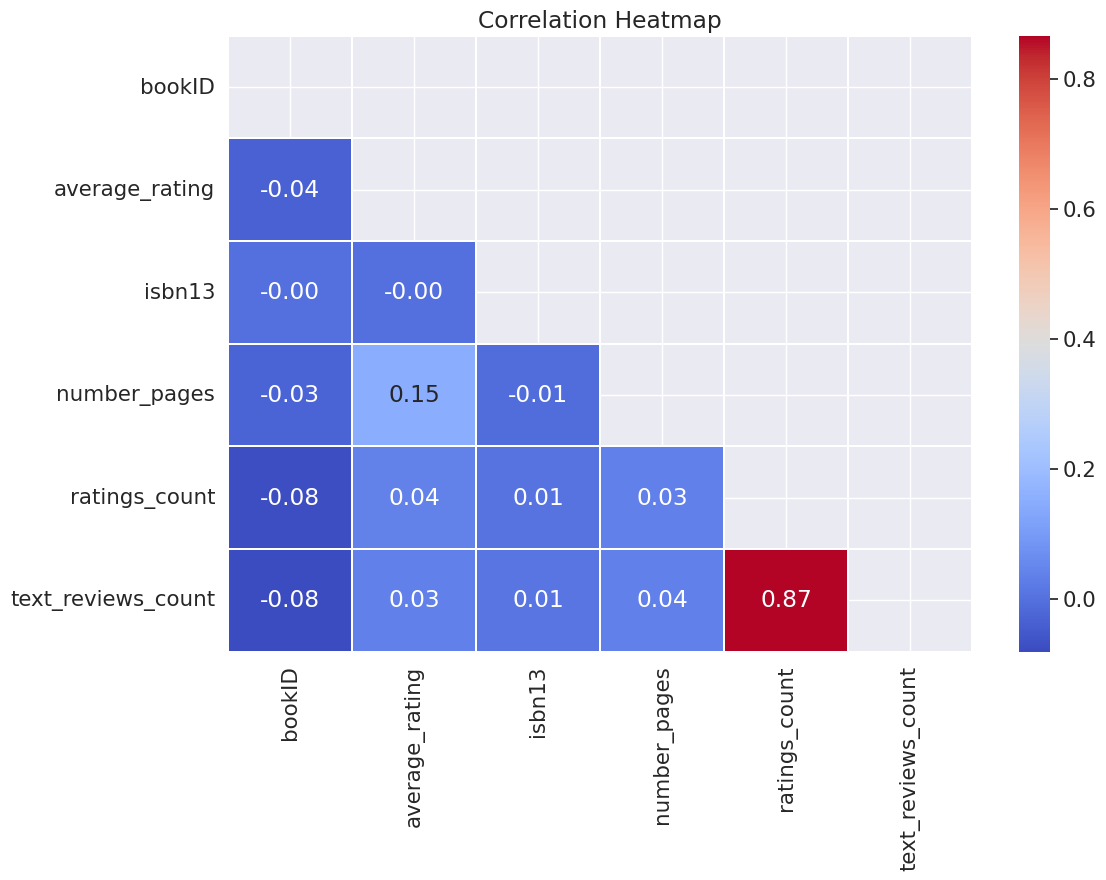

In [ ]:
# Calculate the correlation matrix
corr_matrix = data.corr()

# Changing the matrix shape to remove redundant data
matrix = np.triu(data.corr())

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.05, mask=matrix)
plt.title('Correlation Heatmap')

# Show the plot
plt.show()

The matrix shows two notable relationships: `'average_rating'` vs. `'number_pages'` and `'ratings_count'` vs. `'text_reviews_count'`.

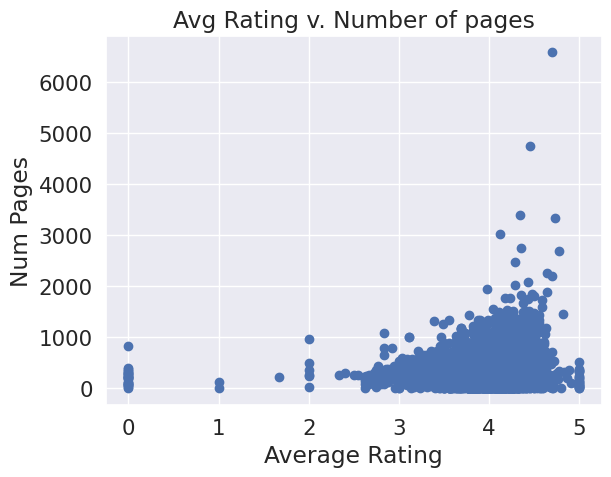

In [ ]:
x = data.average_rating
y = data.number_pages

plt.scatter(x, y)
plt.title("Avg Rating v. Number of pages")
plt.xlabel("Average Rating")
plt.ylabel("Num Pages")
plt.show()

What books could be above 1000 pages long?

In [ ]:
above_1000 = data[data["number_pages"] > 1000]

In [ ]:
above_1000.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 217 entries, 4 to 11023
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              217 non-null    int64  
 1   title               217 non-null    object 
 2   authors             217 non-null    object 
 3   average_rating      217 non-null    float64
 4   isbn                217 non-null    object 
 5   isbn13              217 non-null    int64  
 6   language_code       217 non-null    object 
 7   number_pages        217 non-null    int64  
 8   ratings_count       217 non-null    int64  
 9   text_reviews_count  217 non-null    int64  
 10  publication_date    217 non-null    object 
 11  publisher           217 non-null    object 
dtypes: float64(1), int64(5), object(6)
memory usage: 22.0+ KB


In [ ]:
print(above_1000.title)

4        Harry Potter Boxed Set  Books 1-5 (Harry Potte...
6             Harry Potter Collection (Harry Potter  #1-6)
21       J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...
22       The Lord of the Rings (The Lord of the Rings  ...
24       The Lord of the Rings (The Lord of the Rings  ...
                               ...                        
10535                           Whirlwind (Asian Saga  #6)
10543           War and Remembrance (The Henry Family  #2)
10749    The Sword of Truth  Boxed Set I: Wizard's Firs...
10906               Remembrance of Things Past (Boxed Set)
11023              Judas Unchained (Commonwealth Saga  #2)
Name: title, Length: 217, dtype: object


We can see here that most of the book entries that are above 1000 pages are collections. What does the relationship look like if we were to only look at books that are less than 1000 pages?

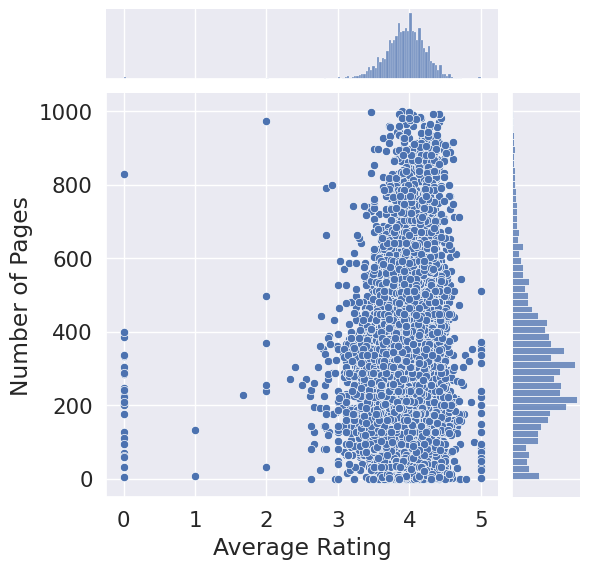

In [ ]:
below_1000 = data[data["number_pages"] < 1000]

x = below_1000.average_rating
y = below_1000.number_pages

ax = sns.jointplot(x=x, y=y, data = below_1000)
ax.set_axis_labels("Average Rating", "Number of Pages")

We minimize the number of collections of books as single entries by only looking at entries that are less than 1000 pages. Based on this graph, most books recieve a rating between 3-5 and most books in the dataset are between 200-400 pages long.

Next let's inspect the second relationship indicated by the heatmap: `'ratings_count'` vs. `'text_reviews_count'`.

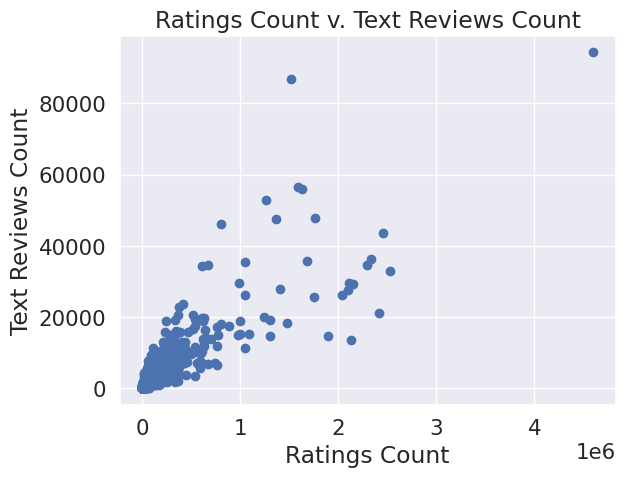

In [ ]:
x = data.ratings_count
y = data.text_reviews_count

plt.scatter(x, y)
plt.title("Ratings Count v. Text Reviews Count")
plt.xlabel("Ratings Count")
plt.ylabel("Text Reviews Count")
plt.show()

It is difficult to make any conclusions about this relationship based on this graph. There are some extreme values represented here. The two potential outliers exist beyond 60000 review counts.

Text(1, 5, 'R² = 0.74')

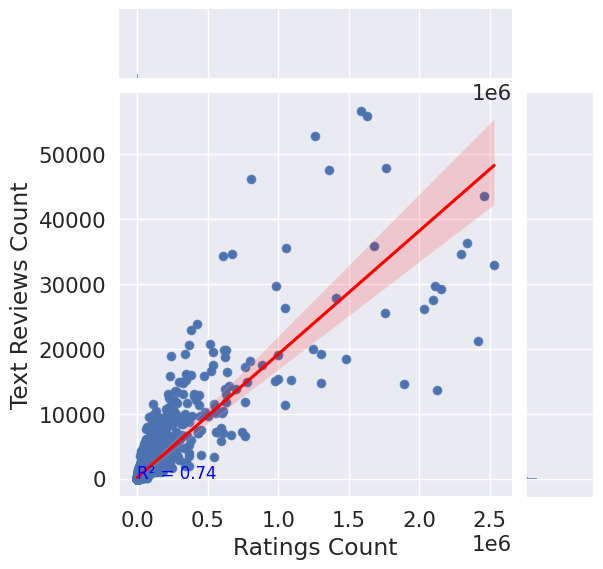

In [ ]:
from scipy import stats
below_60000 = data[data["text_reviews_count"] < 60000]

x = below_60000.ratings_count
y = below_60000.text_reviews_count

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
r_squared = r_value**2

ax = sns.jointplot(x=x, y=y, data = below_60000)
sns.regplot(x=x, y=y, data= below_60000, ci=95, line_kws={"color": "red"})
ax.set_axis_labels("Ratings Count", "Text Reviews Count")
plt.text(1, 5, f'R² = {r_squared:.2f}', fontsize=12, color='blue')

After honing in on the data with text review counts below 60000, we can see that there is a potential positive correlation. However, a linear regression shows that the the relationship is not very strong, with an R² value of 0.74.

Next let's study the relationship between the average rating and the total number of ratings for each entry.


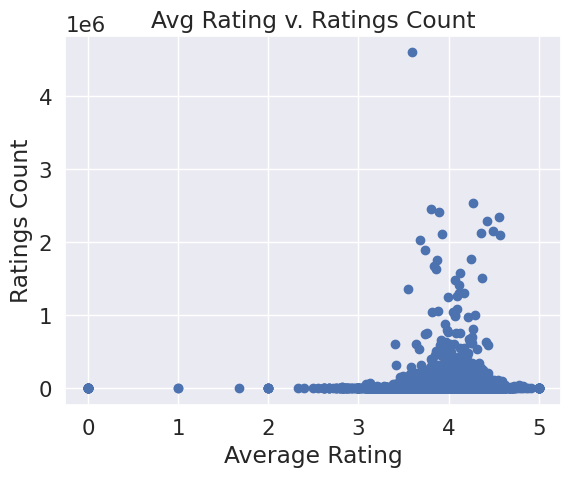

In [ ]:
x = data.average_rating
y = data.ratings_count

plt.scatter(x, y)
plt.title("Avg Rating v. Ratings Count")
plt.xlabel("Average Rating")
plt.ylabel("Ratings Count")
plt.show()

We can see that there is an outlier that is shows a point that has above 4 million ratings count. Let's focus on the data that below 3 million:

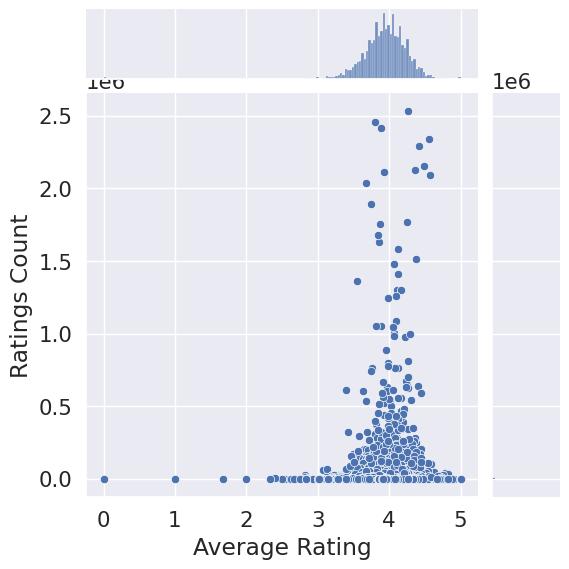

In [ ]:
below_300k = data[data["ratings_count"] < 3000000]

x = below_300k.average_rating
y = below_300k.ratings_count

ax = sns.jointplot(x=x, y=y, data = below_300k)
ax.set_axis_labels("Average Rating", "Ratings Count")

The most frequent average rating of books with high numbers of ratings looks to be around 4.

Let's explore some additional parts of the data:

Which books are the highest rated? Let's look at the top 20 books.

<Axes: xlabel='average_rating', ylabel='title'>

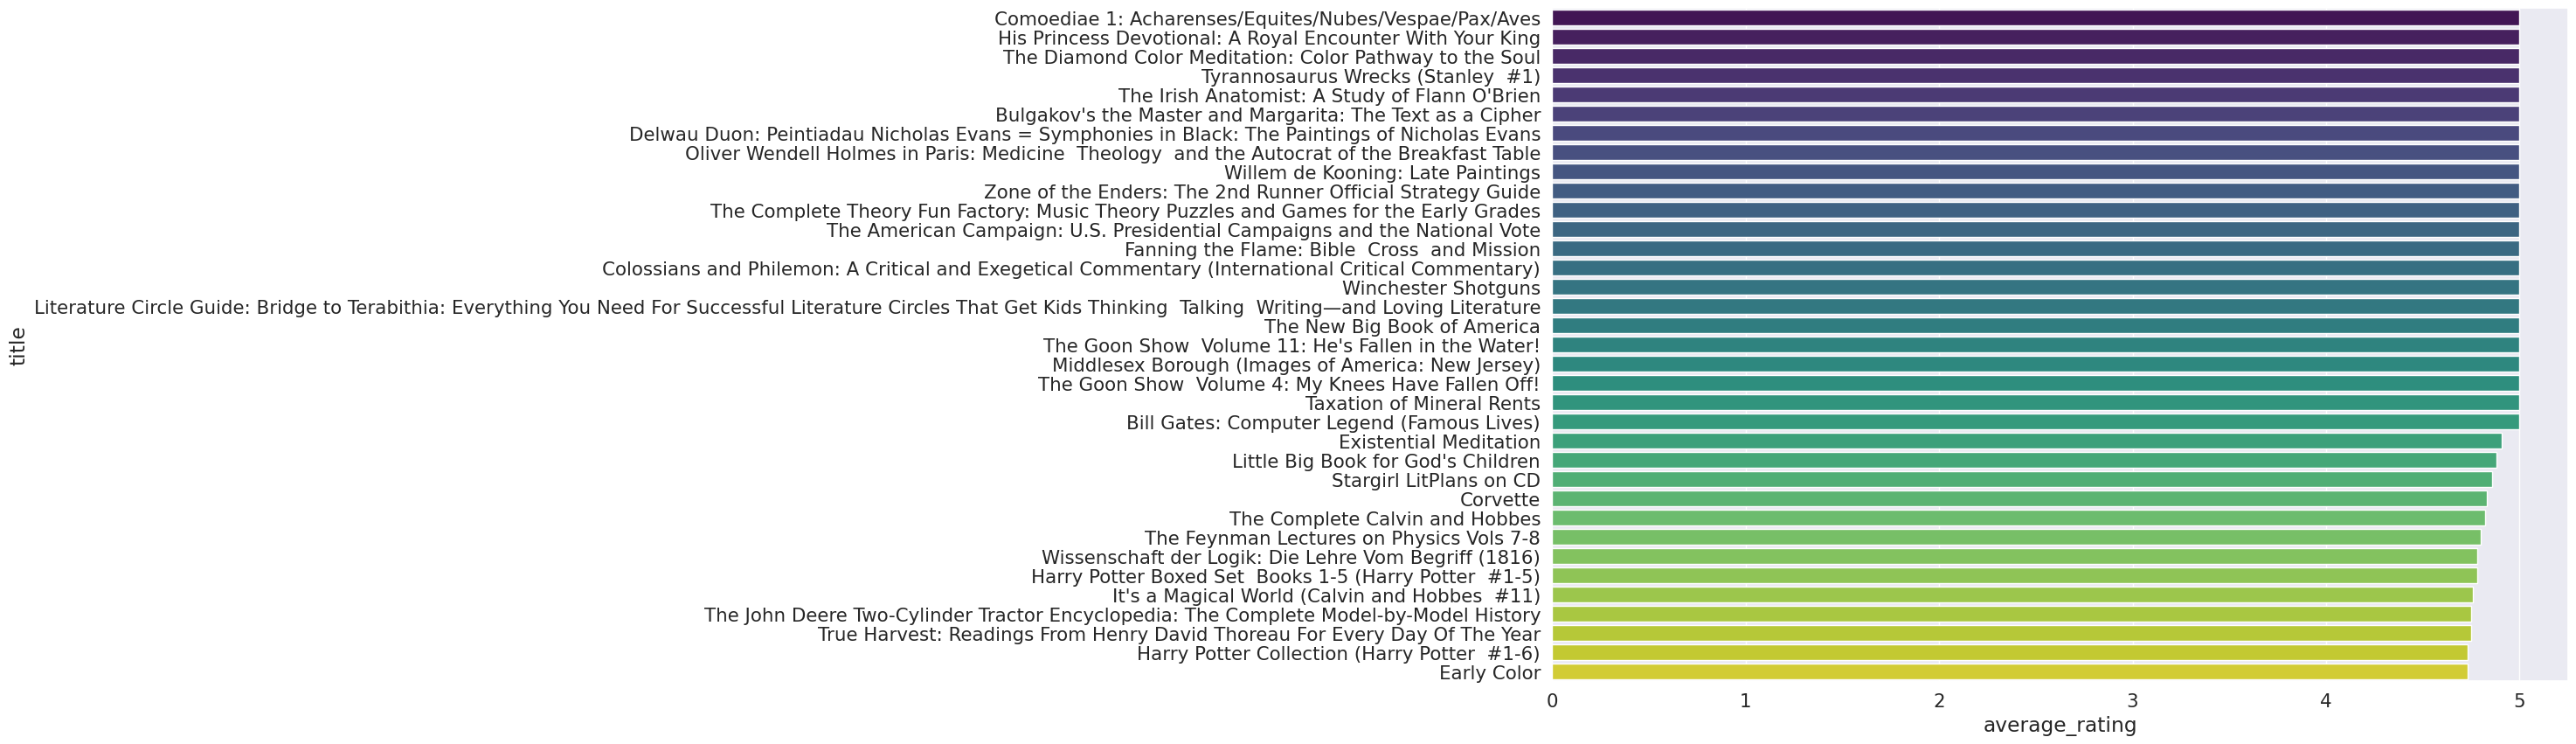

In [ ]:
highest_rated = data.sort_values('average_rating', ascending = False).head(35).set_index('title')
plt.figure(figsize=(15,10))
sns.barplot(x=highest_rated['average_rating'], y=highest_rated.index, palette = 'viridis')

While these books have the highest rating, they may not have many number of ratings.

Let's also look at the 10 books that have been rated the most number of times.

<Axes: xlabel='ratings_count', ylabel='title'>

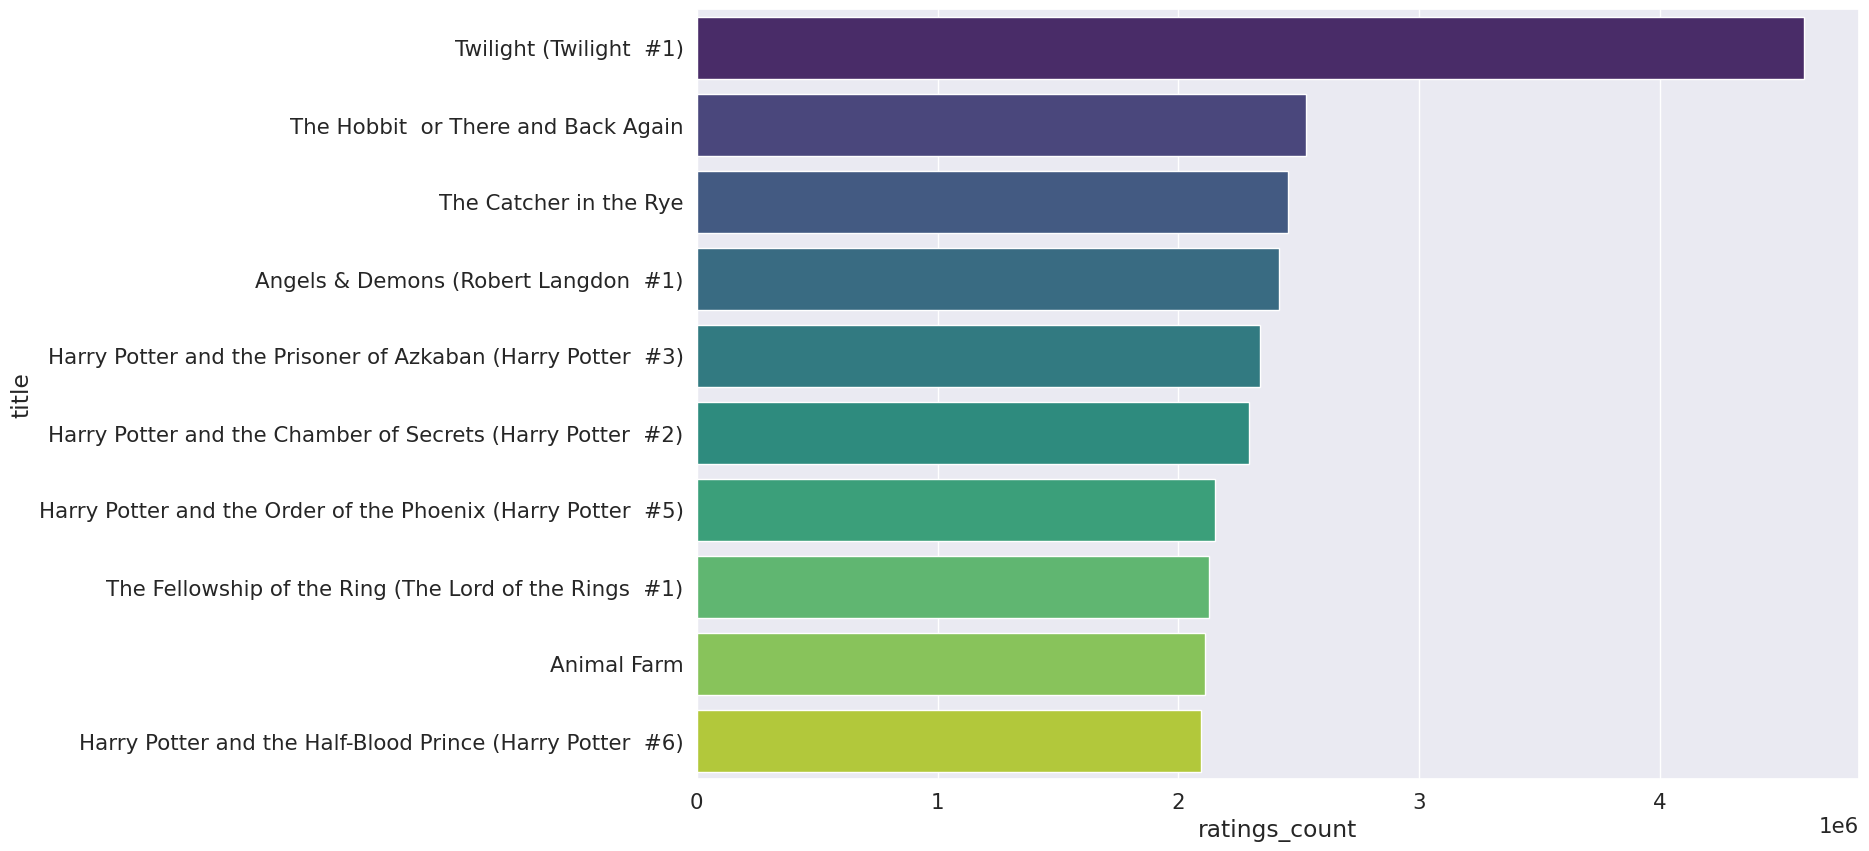

In [ ]:
most_rated = data.sort_values('ratings_count', ascending = False).head(10).set_index('title')
plt.figure(figsize=(15,10))
sns.barplot(x=most_rated['ratings_count'], y=most_rated.index, palette = 'viridis')

We see here that the most rated books are Twilight and some classics such as The Lord of the Rings series, The Catcher in the Rye, and the Harry Potter Series.

Let's check the top authors with the most books.


                  authors  average_rating
Stephen King           40        3.973500
P.G. Wodehouse         40        4.147250
Rumiko Takahashi       39        4.186667
Orson Scott Card       35        3.779143
Agatha Christie        33        3.989091
Piers Anthony          30        3.716667
Sandra Brown           29        3.742069
Mercedes Lackey        29        4.039310
Dick Francis           28        3.962143
James Patterson        23        3.906087


Text(0.5, 1.0, 'Top ten Authors')

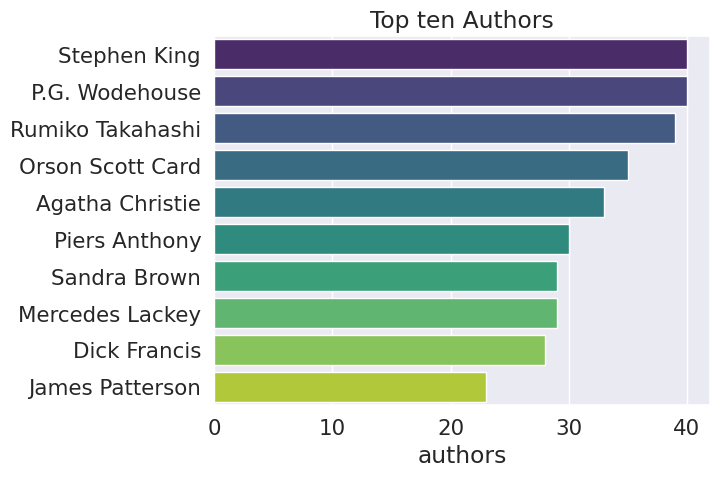

In [ ]:
top_authors = (data['authors'].value_counts()).iloc[:10]
top_authors = top_authors.sort_values(ascending=False)

top_10_authors = data['authors'].value_counts().head(10).index.tolist()
filtered_df = data[data['authors'].isin(top_10_authors)]
average_ratings = filtered_df.groupby('authors')['average_rating'].mean()


auth_reviews = pd.concat([top_authors, average_ratings], axis=1)

print(auth_reviews)

sns.barplot(x=auth_reviews['authors'], y=auth_reviews.index, palette = 'viridis')
#auth_reviews['authors'].plot(kind='barh')

plt.title('Top ten Authors')

How is the average rating for each of the top ten authors?

(3.5, 4.25)

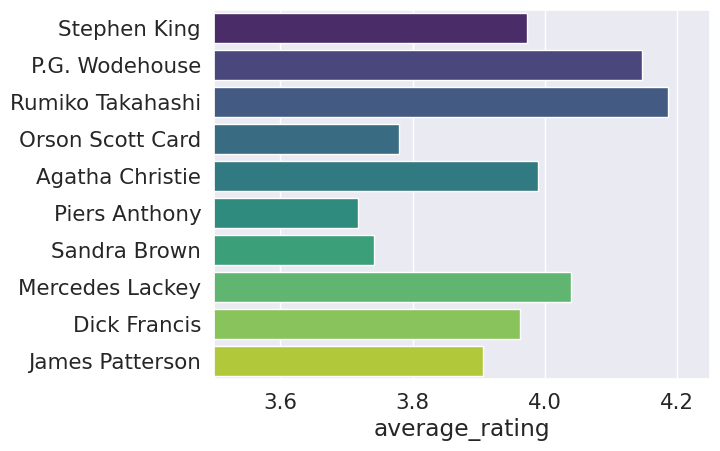

In [ ]:
sns.barplot(x=auth_reviews['average_rating'], y=auth_reviews.index, palette = 'viridis')
plt.xlim(3.5, 4.25)

In this figure we can see the top ten authors and their respective average ratings. The author with the highest average rating is Rumiko Takahashi and the author with the lowest average rating is Piers Anthony.

# Unsupervised Learning Models

We will try three unsupervised learning models to see which one would be most effective for providing book recommendations. We will employ visual analysis and the Silhouette score to determine the best possible model.

The three models tested will be K-Means, Hierarchical Clustering, and UMAP.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

!pip install umap-learn
import umap

### Preprocessing

In [ ]:
df=data.copy()

for column in df.columns:
    if df[column].dtype == 'object':
        df[column + '_encoded'] = df[column].astype('category').cat.codes
        df.drop(column, axis=1, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11123 entries, 0 to 11122
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   bookID                    11123 non-null  int64  
 1   average_rating            11123 non-null  float64
 2   isbn13                    11123 non-null  int64  
 3   number_pages              11123 non-null  int64  
 4   ratings_count             11123 non-null  int64  
 5   text_reviews_count        11123 non-null  int64  
 6   title_encoded             11123 non-null  int16  
 7   authors_encoded           11123 non-null  int16  
 8   isbn_encoded              11123 non-null  int16  
 9   language_code_encoded     11123 non-null  int8   
 10  publication_date_encoded  11123 non-null  int16  
 11  publisher_encoded         11123 non-null  int16  
dtypes: float64(1), int16(5), int64(5), int8(1)
memory usage: 641.0 KB


Here we'll create a dataframe with the only relavent numerical columns that we will look at for analyzing with unsupervised models.

In [ ]:
df = df.drop("bookID", axis = 1)
df = df.drop("isbn13", axis = 1)
df = df.drop("title_encoded", axis = 1)
df = df.drop("authors_encoded", axis = 1)
df = df.drop("isbn_encoded", axis = 1)
df = df.drop("language_code_encoded", axis = 1)
df = df.drop("publication_date_encoded", axis = 1)
df = df.drop("publisher_encoded", axis=1)
#df = df.drop("number_pages", axis = 1)
df = df.drop("text_reviews_count", axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11123 entries, 0 to 11122
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   average_rating  11123 non-null  float64
 1   number_pages    11123 non-null  int64  
 2   ratings_count   11123 non-null  int64  
dtypes: float64(1), int64(2)
memory usage: 260.8 KB


In [ ]:
print((df.isnull().sum() / len(df)) * 100)

average_rating    0.0
number_pages      0.0
ratings_count     0.0
dtype: float64


In [ ]:
ss=StandardScaler()
X = pd.DataFrame(ss.fit_transform(df), columns=df.columns)

## K-means

In [ ]:

# You just want the first two principal components
pca = PCA(n_components=2)

# Get the components by
# calling `fit_transform()` method with the data
pca_components = pca.fit_transform(X)


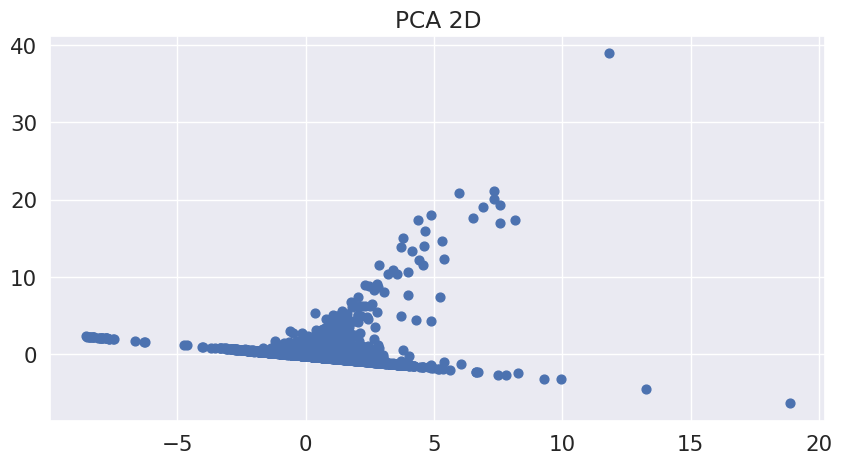

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(pca_components[:, 0], pca_components[:, 1], s=40)
plt.title('PCA 2D')
plt.axis('on')
plt.show()

In [ ]:
k_val = list()
sse = list()
for i in range(2, 30):
    kmeans = KMeans(n_clusters=i, random_state=123, n_init=10).fit(X)
    k_val.append(i)
    sse.append(kmeans.inertia_)

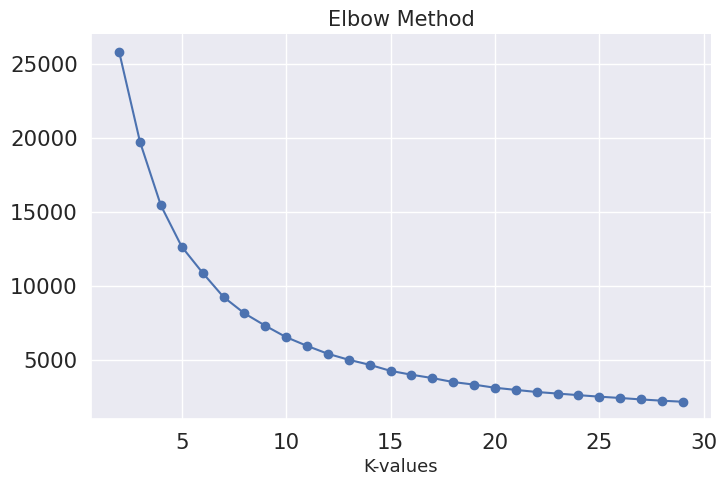

In [ ]:

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(k_val, sse)
ax.scatter(k_val, sse, c='b')

ax.set_title('Elbow Method', fontsize=15)
ax.set_xlabel('K-values', fontsize=13)


ax.spines[['top', 'right']].set_visible(False)

plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


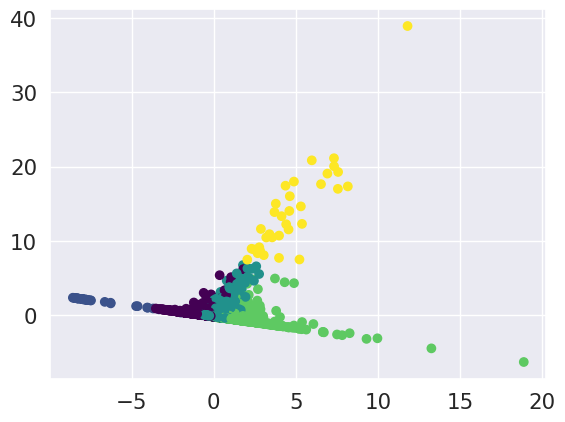

In [ ]:
# Reduce it to two components for visualization
X_pca = PCA(2).fit_transform(X)

# Calculate predicted values.
y_pred = KMeans(n_clusters=5, random_state=0).fit_predict(X)
labels = kmeans.labels_

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap='viridis')
plt.show()


There are a couple of outliers here that may be skewing the results. Let us remove them to see if the clustering is affected in any way.

In [ ]:
# Identify outliers and remove them
df.idxmax()

average_rating      624
number_pages       6497
ratings_count     10336
dtype: int64

In [ ]:
df.drop(10336, inplace = True)
df.drop(6497, inplace = True)
df.drop(624, inplace = True)

In [ ]:
ss=StandardScaler()
X = pd.DataFrame(ss.fit_transform(df), columns=df.columns)


# You just want the first two principal components
pca = PCA(n_components=2)

# Get the components by
# calling `fit_transform()` method with the data
pca_components = pca.fit_transform(X)

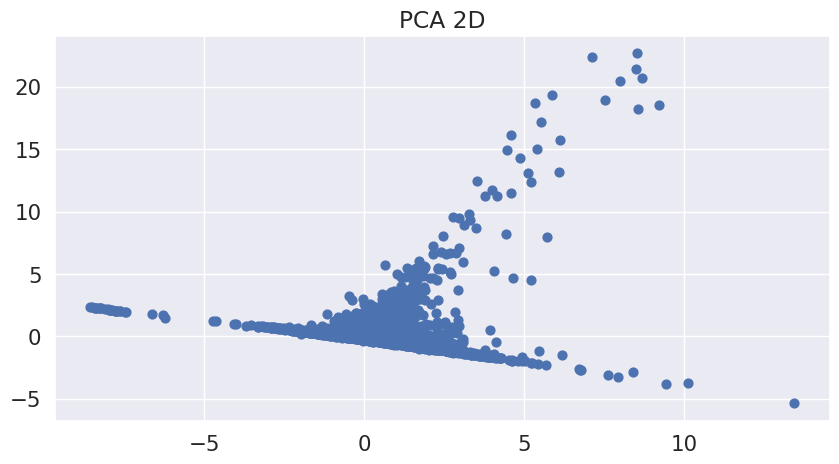

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(pca_components[:, 0], pca_components[:, 1], s=40)
plt.title('PCA 2D')
plt.axis('on')
plt.show()

In [ ]:
k_val = list()
sse = list()
for i in range(2, 30):
    kmeans = KMeans(n_clusters=i, random_state=123, n_init=10).fit(X)
    k_val.append(i)
    sse.append(kmeans.inertia_)

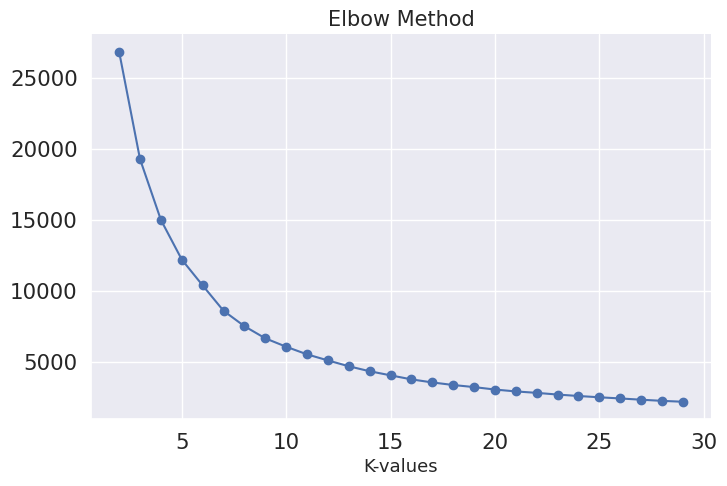

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(k_val, sse)
ax.scatter(k_val, sse, c='b')

ax.set_title('Elbow Method', fontsize=15)
ax.set_xlabel('K-values', fontsize=13)


ax.spines[['top', 'right']].set_visible(False)

plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


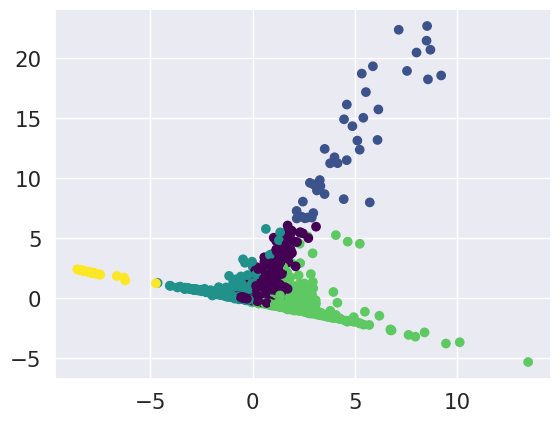

In [ ]:
# Reduce it to two components for visualization
X_pca = PCA(2).fit_transform(X)

# Calculate predicted values.
y_pred = KMeans(n_clusters=5, random_state=0).fit_predict(X)
labels = kmeans.labels_

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap='viridis')
plt.show()

In [ ]:
labels = KMeans(n_clusters=3, random_state=123).fit_predict(X)
print(metrics.silhouette_score(X, labels, metric='euclidean'))
agg_kmeans = metrics.silhouette_score(X, labels, metric='euclidean')

sil_scores = {}
sil_scores['KMeans'] = agg_kmeans
print(sil_scores)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.3999639393941552
{'KMeans': 0.3999639393941552}


We can see that the K-means method does not have visually notable clusters. Additionally, the silhouette score for this method is very low, at 0.39996. Let's next attempt the Hierachical Clustering.

## Hierarchical Clustering

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Standardize the data.
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

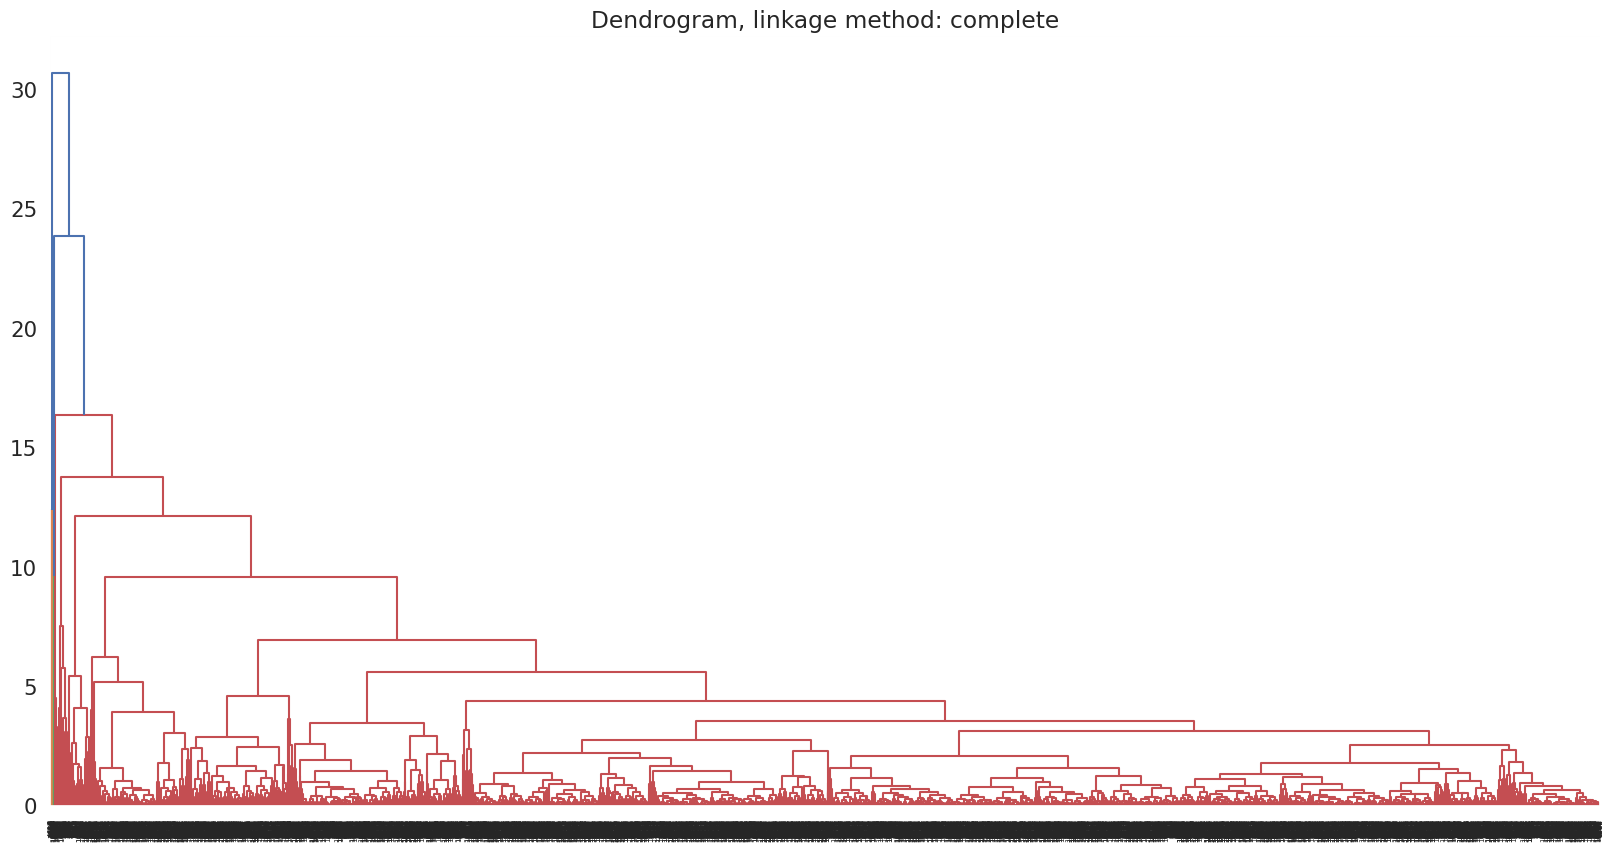

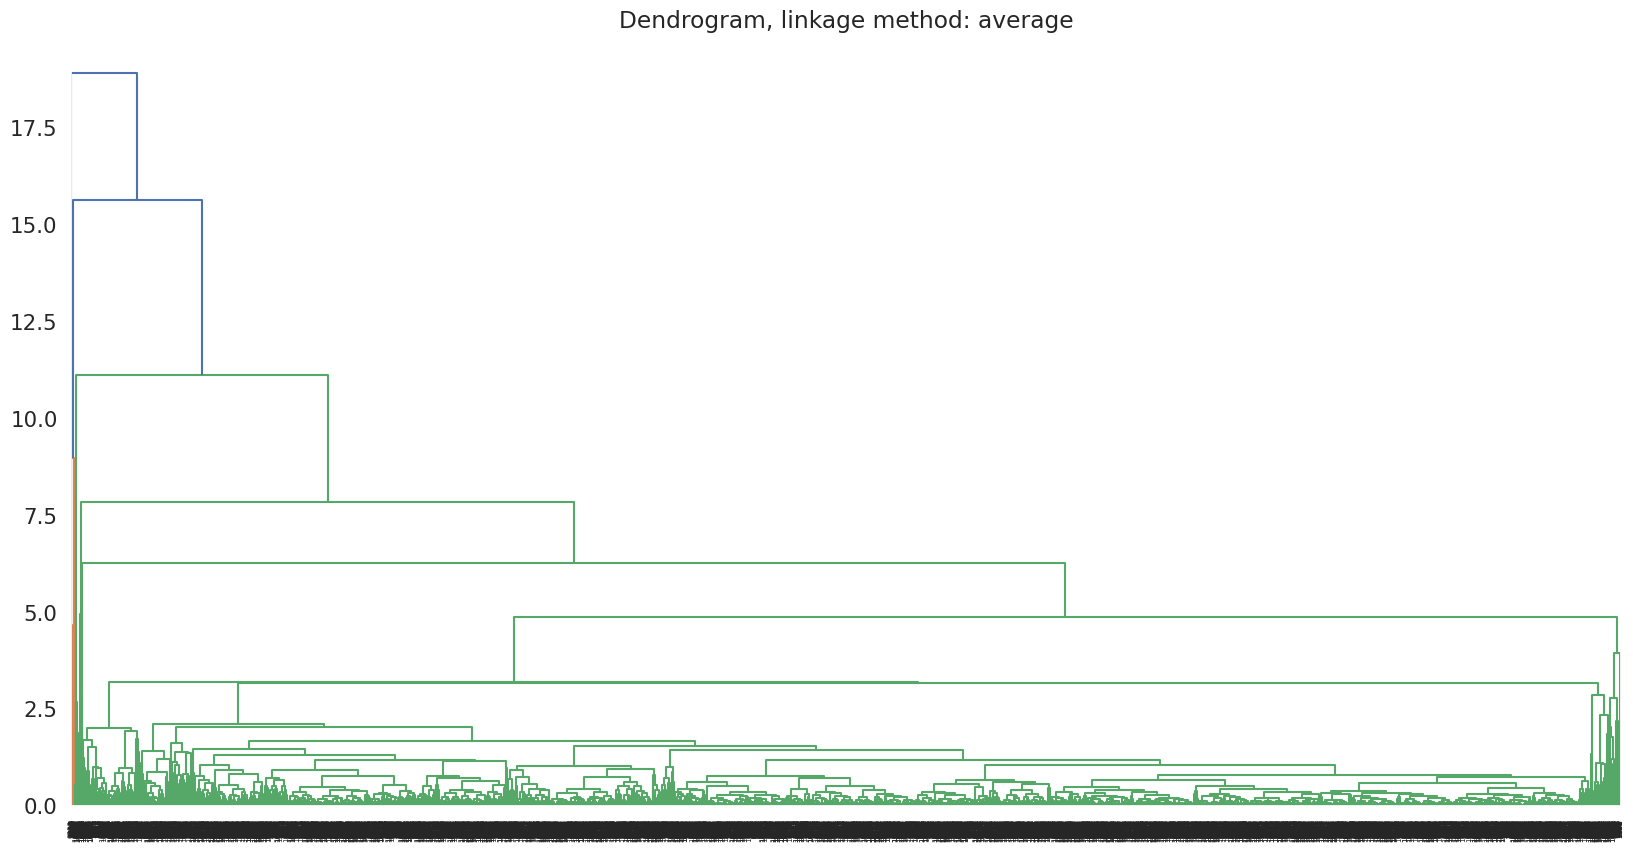

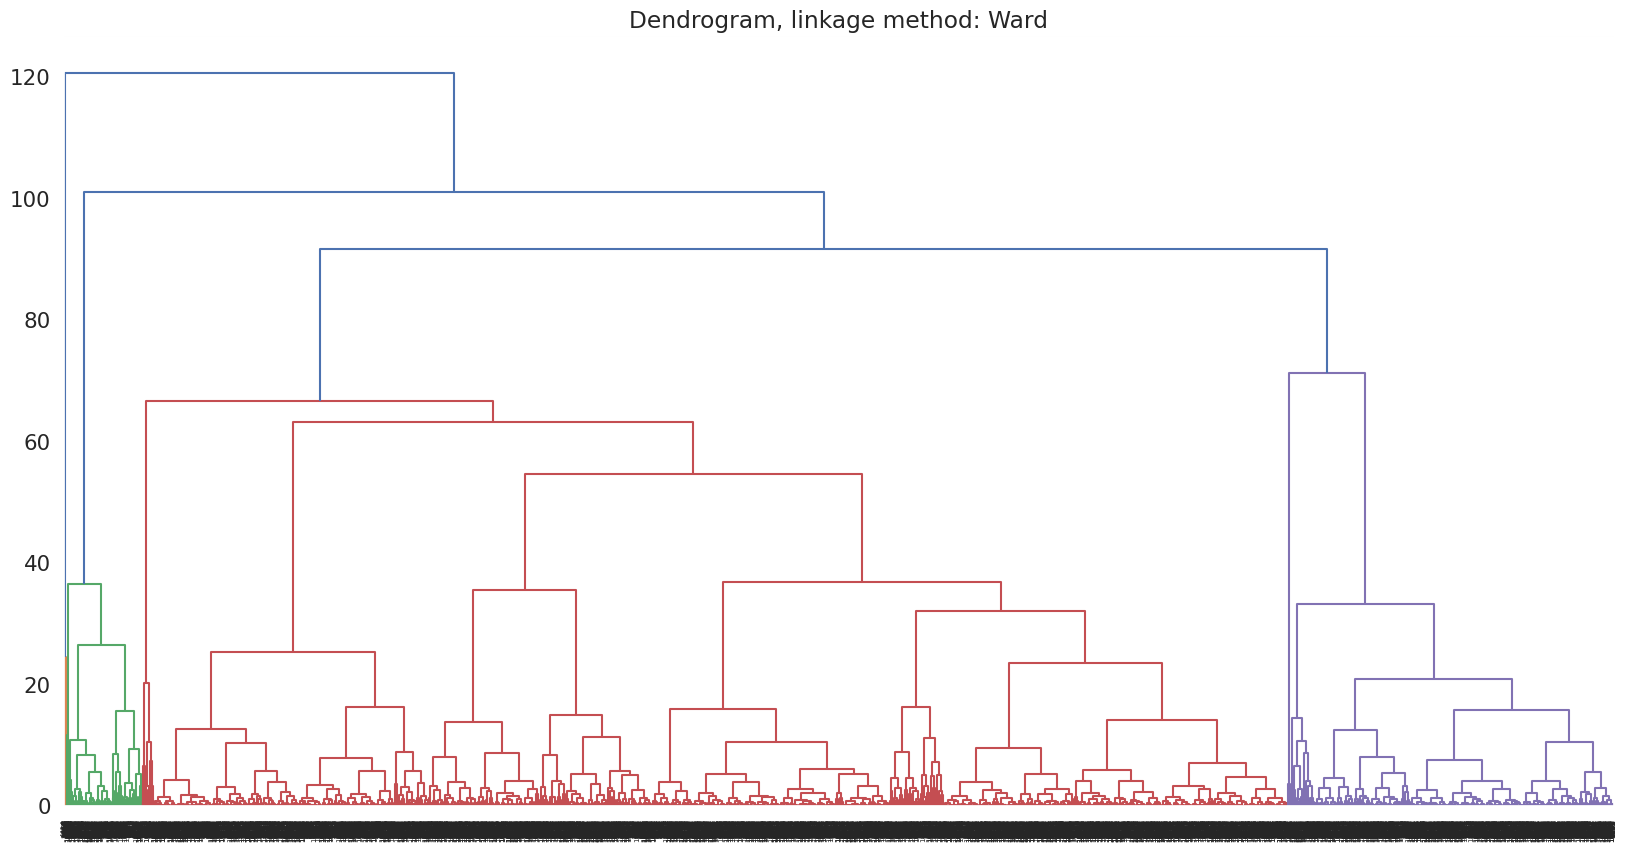

In [ ]:
plt.figure(figsize=(20,10))
plt.title("Dendrogram, linkage method: complete")
dendrogram(linkage(X_std, method='complete'))
plt.show()

plt.figure(figsize=(20,10))
plt.title("Dendrogram, linkage method: average")
dendrogram(linkage(X_std, method='average'))
plt.show()

plt.figure(figsize=(20,10))
plt.title("Dendrogram, linkage method: Ward")
dendrogram(linkage(X_std, method='ward'))
plt.show()

Of the three linkage methods, the ward method seems visually most reasonable.

In [ ]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage="average",
                                      affinity='cosine',
                                      n_clusters=2)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

print("Silhouette score of linkage method average: {}".format(
    metrics.silhouette_score(X_std, clusters, metric='euclidean')))
print('\n')
agg_avg = metrics.silhouette_score(X_std, clusters, metric='euclidean')

# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage="complete",
                                      affinity='cosine',
                                      n_clusters=2)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

print("Silhouette score of linkage method complete: {}".format(
    metrics.silhouette_score(X_std, clusters, metric='euclidean')))
print('\n')
agg_comp = metrics.silhouette_score(X_std, clusters, metric='euclidean')

# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage="ward",
                                      affinity='euclidean',
                                      n_clusters=2)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

print("Silhouette score of linkage method ward: {}".format(
    metrics.silhouette_score(X_std, clusters, metric='euclidean')))
agg_ward = metrics.silhouette_score(X_std, clusters, metric='euclidean')

Silhouette score of linkage method average: 0.2926770091080707


Silhouette score of linkage method complete: 0.27028337852299344


Silhouette score of linkage method ward: 0.9036752174009286


We can see here that the silhouette score is best for the ward linkage method, corresponding well with the visuals of the dendrogram.

In [ ]:
sil_scores['Agg_Avg_Method'] = agg_avg
sil_scores['Agg_Comp_Method'] = agg_comp
sil_scores['Agg_Ward_Method'] = agg_ward
print(sil_scores)

{'KMeans': 0.3999639393941552, 'Agg_Avg_Method': 0.2926770091080707, 'Agg_Comp_Method': 0.27028337852299344, 'Agg_Ward_Method': 0.9036752174009286}


## UMAP

In [ ]:
umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X)

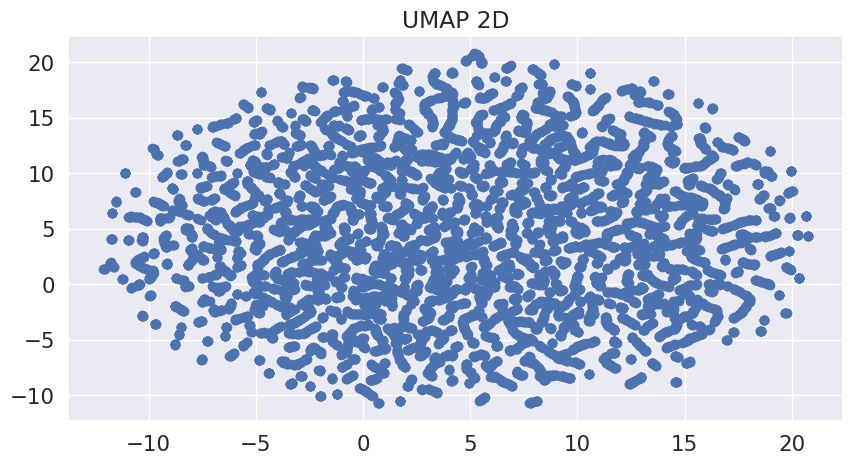

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.title('UMAP 2D')
plt.axis('on')
plt.show()

Upon initial observations, the UMAP plot shows a homogeneous distribution of the data. There are no discernable clusters or groups here. Let us try to adjust the hyperparameters to see if any improvements can be made. We'll start by examining what happens when we adjust the number of near neighbors:

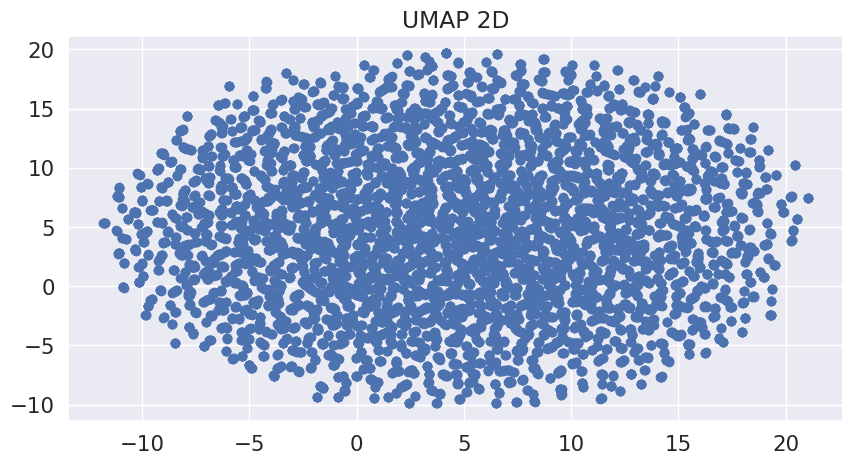

In [ ]:
umap_results2 = umap.UMAP(n_neighbors=3,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X)

plt.figure(figsize=(10,5))
plt.scatter(umap_results2[:, 0], umap_results2[:, 1])
plt.title('UMAP 2D')
plt.axis('on')
plt.show()

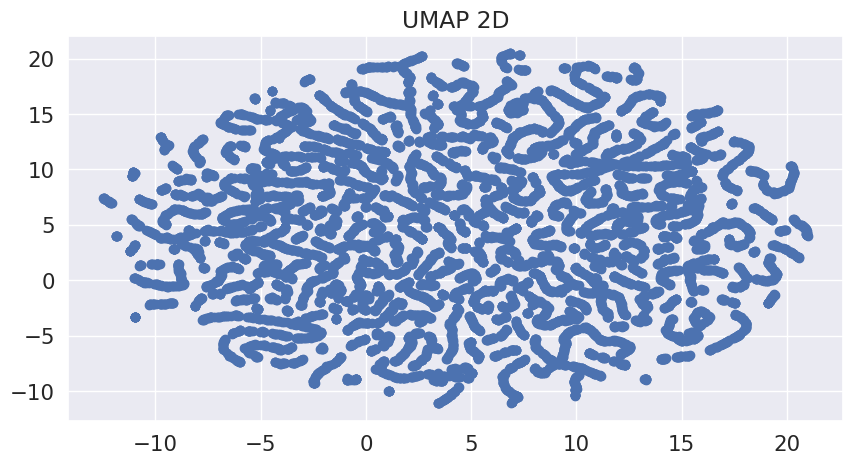

In [ ]:
umap_results3 = umap.UMAP(n_neighbors=7,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X)

plt.figure(figsize=(10,5))
plt.scatter(umap_results3[:, 0], umap_results3[:, 1])
plt.title('UMAP 2D')
plt.axis('on')
plt.show()

Adjust the `'n_neighbors'` hyperparameter did not cause any significant visual changes. Next we will attempt to adjust the `'min_dist'`.

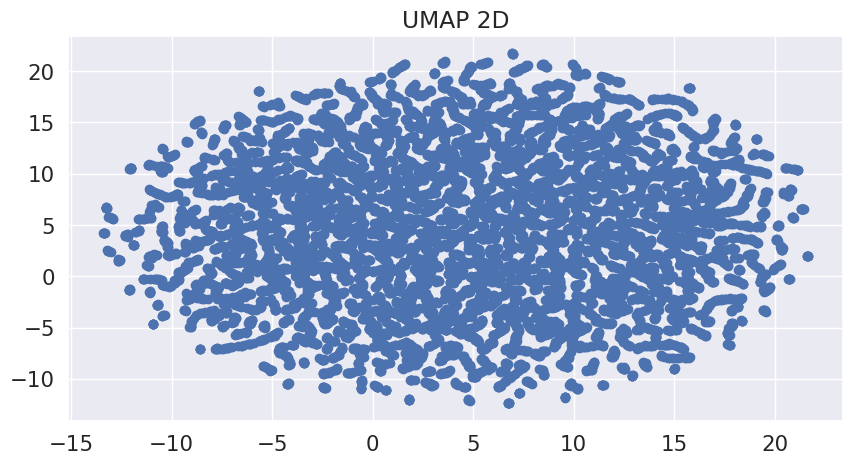

In [ ]:
umap_results4 = umap.UMAP(n_neighbors=5,
                      min_dist=0.5,
                      metric='correlation').fit_transform(X)

plt.figure(figsize=(10,5))
plt.scatter(umap_results4[:, 0], umap_results4[:, 1])
plt.title('UMAP 2D')
plt.axis('on')
plt.show()

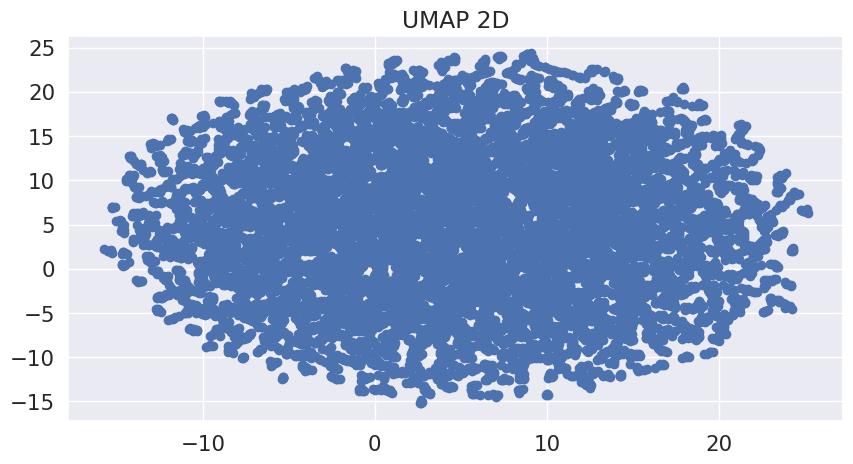

In [ ]:
umap_results5 = umap.UMAP(n_neighbors=5,
                      min_dist=1,
                      metric='correlation').fit_transform(X)

plt.figure(figsize=(10,5))
plt.scatter(umap_results5[:, 0], umap_results5[:, 1])
plt.title('UMAP 2D')
plt.axis('on')
plt.show()

Unfortumately, adjusting the `'min_dist'` hyperparameter also did not yield better results.

In [ ]:
list(sil_scores.keys())
sil_scores

{'KMeans': 0.3999639393941552,
 'Agg_Avg_Method': 0.2926770091080707,
 'Agg_Comp_Method': 0.27028337852299344,
 'Agg_Ward_Method': 0.9036752174009286}

In [ ]:
model_eval=pd.DataFrame({'Model':list(sil_scores.keys()), 'Silhouette Score': [agg_kmeans,agg_avg, agg_comp, agg_ward]})
print(model_eval)

             Model  Silhouette Score
0           KMeans          0.399964
1   Agg_Avg_Method          0.292677
2  Agg_Comp_Method          0.270283
3  Agg_Ward_Method          0.903675


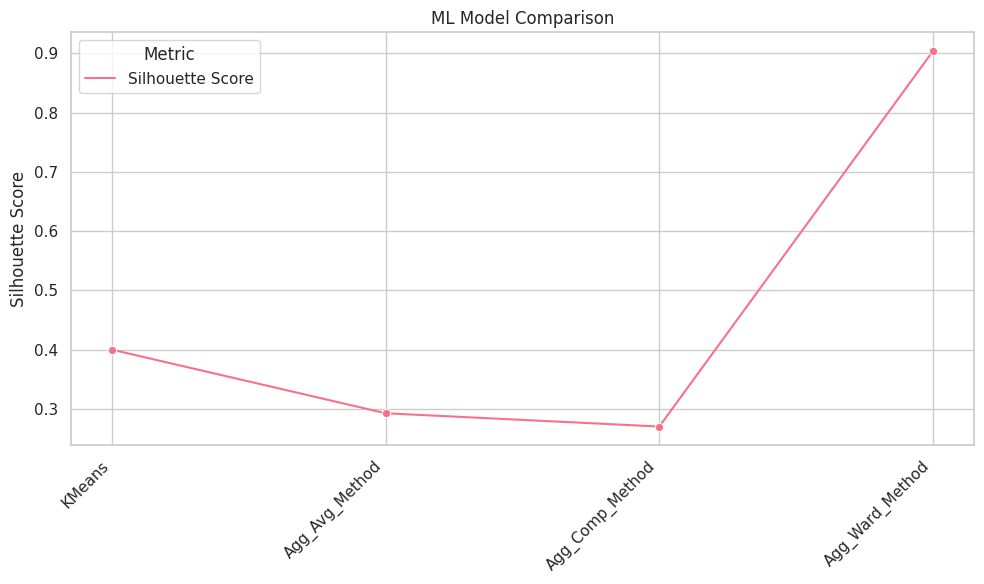

In [ ]:

# Melt the DataFrame for easier plotting
melted_df = model_eval.melt(id_vars='Model', var_name='Metric', value_name='Score')
sns.set(style="whitegrid", context="notebook")

# Create the line chart
plt.figure(figsize=(10, 6))
palette = sns.color_palette("husl", 4)  # Choose a color palette
sns.lineplot(x='Model', y='Score', hue='Metric', data=melted_df, marker='o', palette=palette)
plt.xticks(rotation=45, ha='right')
plt.title('ML Model Comparison')
plt.xlabel('')
plt.ylabel('Silhouette Score')
plt.tight_layout()

plt.show()

## Conclusion and Recommendation

In this case study we examined the Goodreads dataset to determine a best unsupervised machine learning model for a book recommendation system. The dataset was obtained from Kaggle and was previewed, cleaned, transformed, and standardized. We looked at three unsupervised models to determine the optimal model performance.

The Silhouette Score and visual observation were used to assess the effectiveness of each model and submodel. The initial visual observations for the Kmeans model showed very little effective clustering, this was also confirmed by its low Silhouette score. Next the Hierarchical Clustering method was tested.  Within this method, three linkage methods were tested: average, complete, and ward. Of these the ward linkage method showed the most visually distinct clusters. This was also confirmed by its high Silhouette Score.
Lastly, the UMAP method was also tested. Despite adjusting hyperparameters there were no distinct clusters visible.

Based on these observations, I would recommend the Hierarchical Clustering method with the ward linkage method as the unsupervised model for the book recommendation system.


## Citation
[1] goodreads - Meet your next favorite book. (2023). https://www.goodreads.com/

[2] Goodreads-books. (2019, May 25). Kaggle. https://www.kaggle.com/datasets/jealousleopard/goodreadsbooks

[3] What is an ISBN? | International ISBN Agency. (n.d.). https://www.isbn-international.org/content/what-isbn/10